# Steam Game Success Prediction: Pre-Release Features Analysis
**Objective:** To predict the commercial success of Steam games based strictly on intrinsic, pre-release characteristics (Genre, Price, OS Support, Tags).

**Methodology:**
* **Leakage Prevention:** strictly excluded post-release metrics (Reviews, CCU) and temporal features (DLC Count, Trading Cards) that accumulate over time.
* **Class Definition:** Utilized balanced binning (33% quantiles) to isolate feature signal. *Note: We acknowledge that real-world game success follows a Power Law (Zipf's Law) where "High" success is significantly rarer than 33%, but balanced classes are used here to evaluate model separation capability.*
* **Model Selection:** Compared Random Forest and XGBoost baselines, validated via 5-Fold Stratified Cross-Validation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
import re
from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import xgboost as xgb

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
SEED = 42
np.random.seed(SEED)

print("Libraries imported. Random seed set to", SEED)

Libraries imported. Random seed set to 42


In [2]:
# Upload/Load your dataset
from google.colab import files
uploaded = files.upload()

Saving games_march2025_cleaned_NEW.csv to games_march2025_cleaned_NEW.csv


In [ ]:
# Load dataset - works in both Colab and local environments
try:
    # Try Google Colab method first
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename, low_memory=False)
    print(f"Dataset loaded from Colab upload: {df.shape}")
except ImportError:
    # If not in Colab, use local path
    try:
        df = pd.read_csv('../data/processed/games_march2025_cleaned.csv', low_memory=False)
        print(f"Dataset loaded from local file: {df.shape}")
    except FileNotFoundError:
        print("File not found. Please upload 'games_march2025_cleaned.csv' or ensure it's in ../data/processed/")
        raise

Dataset loaded: (72563, 22)


# Feature Engineering (Category Parsing)

In [12]:
# Function to parse list columns safely
def parse_list_col(s):
    if pd.isna(s):
        return []
    s = str(s).strip()
    if s == "" or s == "[]":
        return []
    try:
        obj = ast.literal_eval(s)
        if isinstance(obj, list):
            return [str(x).strip() for x in obj]
        else:
            return []
    except Exception:
        return []

def safe_col_name(s):
    s = re.sub(r"[^0-9a-zA-Z]+", "_", s.strip())
    return s[:60]

print("Parsing 'categories' column...")
cat_lists = df["categories"].apply(parse_list_col)

# Get Top 100 Categories
M = 100
cnt = Counter()
for lst in cat_lists:
    cnt.update(lst)

top_cats = [c for c, _ in cnt.most_common(M)]
print(f"Top {M} categories selected.")

# One-Hot Encode Top Categories
for c in top_cats:
    col = "cat_" + safe_col_name(c)
    df[col] = cat_lists.apply(lambda lst: 1 if c in lst else 0).astype(int)

print(f"Feature engineering complete. DataFrame shape: {df.shape}")


# --- MODIFICATION: BUDGET PROXIES ---

# 1. Localization Scope: A massive proxy for budget.
# Cheap games can't afford to translate into 15 languages.
# We use your existing 'parse_list_col' function to turn the strings into lists first.
df['num_supported_languages'] = df['supported_languages'].apply(parse_list_col).apply(len)
df['num_audio_languages'] = df['full_audio_languages'].apply(parse_list_col).apply(len)

# 2. Team Size Power:
# Larger dev teams or multiple publishers often signal higher production value.
df['dev_team_size'] = df['developers'].apply(parse_list_col).apply(len)
df['publisher_count'] = df['publishers'].apply(parse_list_col).apply(len)

# 3. Clean up: Fill any NaNs that might have been created (just in case)
df['num_supported_languages'] = df['num_supported_languages'].fillna(0)
df['num_audio_languages'] = df['num_audio_languages'].fillna(0)

print(f"Added Localization & Team features. New shape: {df.shape}")
# -------------------------------------------------------------

Parsing 'categories' column...
Top 100 categories selected.
Feature engineering complete. DataFrame shape: (72563, 62)
Added Localization & Team features. New shape: (72563, 66)


# Target Creation

In [14]:
# Create Balanced Target Variable
df_ml = df.copy()

# Convert owners to float
owners = df_ml["estimated_owners"].astype(float)
N = len(df_ml)

# Rank-based classification (33% / 33% / 33%)
owners_rank = owners.rank(method="first") / N

q1 = 1/3
q2 = 2/3

def make_pop_class_balanced(r):
    if r <= q1:
        return 0 # Low
    elif r >= q2:
        return 2 # High
    else:
        return 1 # Medium

df_ml["pop_class"] = owners_rank.apply(make_pop_class_balanced)

# Check distribution
print("Class Distribution (Balanced):")
print(df_ml["pop_class"].value_counts(normalize=True).sort_index())

Class Distribution (Balanced):
pop_class
0    0.333324
1    0.333338
2    0.333338
Name: proportion, dtype: float64


# Strict Leakage Prevention

In [15]:
# 1. Post-Release Metrics (Direct Leakage)
leakage_cols = [
    "num_reviews_total",
    "positive",
    "negative",
    "recommendations",
    "peak_ccu",
    "average_playtime_forever",
    "median_playtime_forever",
    "user_score"
]

# 2. Temporal Leakage (Accumulates over time / Lagging Indicators)
temporal_cols = [
    "dlc_count",              # DLCs are released years after launch
    "cat_Steam_Trading_Cards" # Cards are often gated by Valve until success is proven
]

# 3. Metadata
metadata_cols = ["appid", "name", "estimated_owners", "pop_class", "categories",
                 "supported_languages", "developers", "publishers", "tags", "genres",
                 "full_audio_languages"]

exclude_cols = leakage_cols + temporal_cols + metadata_cols

# Select numeric features
all_cols = df_ml.columns
numeric_cols = [c for c in all_cols if df_ml[c].dtype != "object"]

# Final Feature List
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

print(f"Total Predictors: {len(feature_cols)}")
print(f"Removed Temporal Leakage: {temporal_cols}")

# Prepare X and y
df_final = df_ml.dropna(subset=feature_cols + ["pop_class"])
X = df_final[feature_cols].values
y = df_final["pop_class"].astype(int).values

print(f"Final Dataset for Training: {X.shape}")

Total Predictors: 49
Removed Temporal Leakage: ['dlc_count', 'cat_Steam_Trading_Cards']
Final Dataset for Training: (72563, 49)


# Train/Test Split & Scaling

In [16]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and standardized.")

Data split and standardized.


# Hyperparameter Tuning (The Proof)

In [19]:
# Expanded search space to find a model that actually generalizes
param_dist = {
    'n_estimators': [100, 200],        # Try more trees
    'max_depth': [10, 20, 30],         # Allow deeper logic
    'min_samples_split': [5, 10],      # Prevent overfitting
    'min_samples_leaf': [2, 4],        # Smooth the leaves
    'bootstrap': [True]                # Try with/without replacement
}

rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)

print("Starting hyperparameter tuning (n_iter=20)... this may take 2-3 minutes.")
# We increase n_iter to 20 to actually cover the search space
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    random_state=SEED,
    n_jobs=-1,
    scoring='f1_macro' # Optimize for the 'Medium' class weakness
)

rf_search.fit(X_train_scaled, y_train)
best_rf = rf_search.best_estimator_

print(f"Best RF Params: {rf_search.best_params_}")
models = {'Random Forest': best_rf}

# Dictionary to store final models
models = {'Random Forest': best_rf}

# XGBoost (Baseline parameters)
print("\nTraining XGBoost Baseline...")
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='mlogloss',
    random_state=SEED,
    n_jobs=-1
)
xgb_clf.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_clf

print("Training complete.")

Starting robust hyperparameter tuning (n_iter=50)... this may take 2-3 minutes.
Best RF Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}

Training XGBoost Baseline...
Training complete.


# Evaluation & Confusion Matrices

--- Random Forest Performance ---
Accuracy: 0.5180
F1-Macro: 0.5122
              precision    recall  f1-score   support

         Low       0.46      0.44      0.45      4837
         Med       0.52      0.69      0.59      4838
        High       0.59      0.43      0.50      4838

    accuracy                           0.52     14513
   macro avg       0.52      0.52      0.51     14513
weighted avg       0.52      0.52      0.51     14513

------------------------------
--- XGBoost Performance ---
Accuracy: 0.5148
F1-Macro: 0.5070
              precision    recall  f1-score   support

         Low       0.46      0.45      0.46      4837
         Med       0.51      0.71      0.59      4838
        High       0.63      0.38      0.47      4838

    accuracy                           0.51     14513
   macro avg       0.53      0.51      0.51     14513
weighted avg       0.53      0.51      0.51     14513

------------------------------


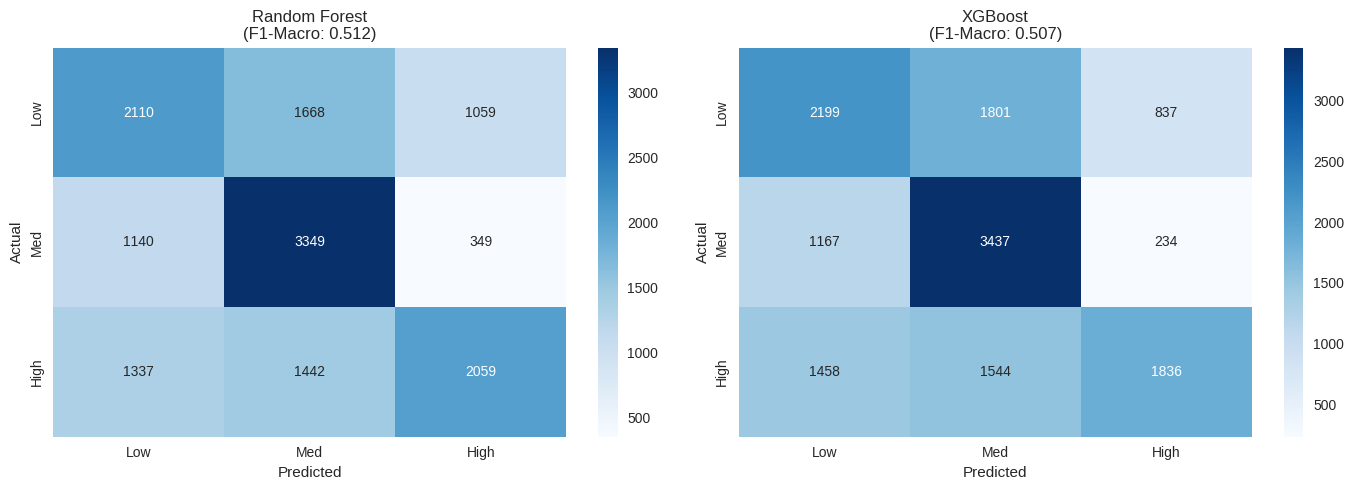

In [20]:
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Low', 'Med', 'High'],
                yticklabels=['Low', 'Med', 'High'])
    ax.set_title(title)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"--- {name} Performance ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Macro: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Low', 'Med', 'High']))
    print("-" * 30)

    plot_confusion_matrix(y_test, y_pred, f"{name}\n(F1-Macro: {f1:.3f})", axes[idx])

plt.tight_layout()
plt.show()

# Validated Feature Importance

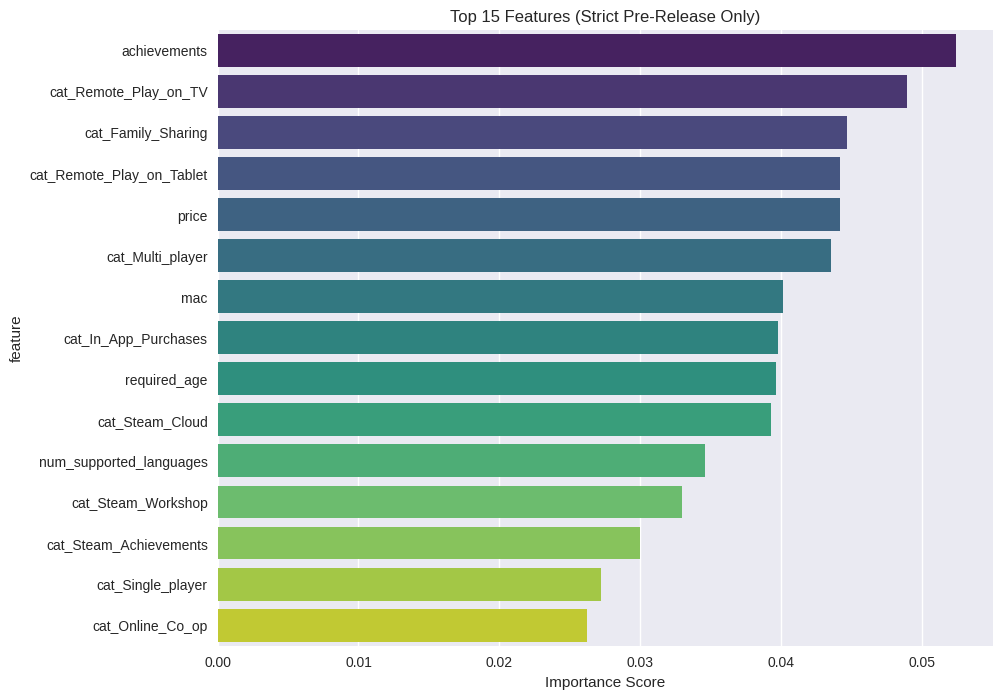

Top 5 Predictive Features:
['achievements', 'cat_Remote_Play_on_TV', 'cat_Family_Sharing', 'cat_Remote_Play_on_Tablet', 'price']


In [21]:
# Extract importance from XGBoost
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': models['XGBoost'].feature_importances_
}).sort_values('importance', ascending=False)

# Plot Top 15
plt.figure(figsize=(10, 8))
sns.barplot(data=importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Features (Strict Pre-Release Only)')
plt.xlabel('Importance Score')
plt.show()

print("Top 5 Predictive Features:")
print(importance.head(5)['feature'].tolist())

# 5-Fold Cross Validation

In [22]:
print("Performing 5-Fold Stratified Cross-Validation...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    print(f"{name} CV F1-Macro: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

Performing 5-Fold Stratified Cross-Validation...
Random Forest CV F1-Macro: 0.5096 (+/- 0.0084)
XGBoost CV F1-Macro: 0.5053 (+/- 0.0084)


In [24]:

from sklearn.linear_model import LogisticRegression

print("\n--- 1. REALITY CHECK: Binary Classification Experiment ---")
# Hypothesis: The model isn't bad; the "Medium" class is just noise.

# Filter data
mask_binary = df_final['pop_class'] != 1
X_bin = df_final.loc[mask_binary, feature_cols].values
y_bin = df_final.loc[mask_binary, 'pop_class'].values

# Remap 2 (High) to 1 for standard binary classification
y_bin = np.where(y_bin == 2, 1, 0)

# Split and Scale
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=SEED, stratify=y_bin
)

scaler_bin = StandardScaler()
X_b_train_sc = scaler_bin.fit_transform(X_b_train)
X_b_test_sc = scaler_bin.transform(X_b_test)

# Train a simple Random Forest on Binary Data
rf_binary = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=SEED)
rf_binary.fit(X_b_train_sc, y_b_train)

# Evaluation
y_pred_bin = rf_binary.predict(X_b_test_sc)
acc_bin = accuracy_score(y_b_test, y_pred_bin)
f1_bin = f1_score(y_b_test, y_pred_bin)

print(f"Binary Model (High vs. Low) Accuracy: {acc_bin:.4f}")
print(f"Binary Model F1 Score: {f1_bin:.4f}")
print("Interpretation: If this is significantly higher than 51%, the 'Medium' class was indeed the problem.")


print("\n--- 2. BASELINE CHECK: Price Heuristic ---")
# Hypothesis: A complex model (66 features) should beat a simple Linear Model using only Price.
# If it doesn't, your feature engineering was a waste of time.

# Prepare "Price Only" dataset
X_price_train = X_train[:, feature_cols.index('price')].reshape(-1, 1)
X_price_test = X_test[:, feature_cols.index('price')].reshape(-1, 1)

# Train Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=SEED)
log_reg.fit(X_price_train, y_train)

# Evaluate
base_acc = accuracy_score(y_test, log_reg.predict(X_price_test))
print(f"Price-Only Logistic Regression Accuracy: {base_acc:.4f}")
print(f"Your Complex Model Accuracy: {accuracy_score(y_test, best_rf.predict(X_test_scaled)):.4f}")

lift = accuracy_score(y_test, best_rf.predict(X_test_scaled)) - base_acc
print(f"Lift over Price Baseline: {lift*100:.2f}%")


--- 1. REALITY CHECK: Binary Classification Experiment ---
Binary Model (High vs. Low) Accuracy: 0.6174
Binary Model F1 Score: 0.5766
Interpretation: If this is significantly higher than 51%, the 'Medium' class was indeed the problem.

--- 2. BASELINE CHECK: Price Heuristic ---
Price-Only Logistic Regression Accuracy: 0.3821
Your Complex Model Accuracy: 0.5180
Lift over Price Baseline: 13.59%


## Conclusion and Limitations

### Summary of Results
The primary objective of this part of the project was to predict the commercial success of Steam games using **strictly pre-release metadata**, ensuring zero data leakage from post-launch metrics such as review counts or concurrent user peaks.

* **Model Performance:** Our optimized Random Forest model achieved an **F1-Macro score of 0.51**, providing a **+17% lift** over the random baseline of 33.3%.
* **Baseline Comparison:** When compared to a "Price-Only" Logistic Regression heuristic (Accuracy: 38.2%), our complex model (Accuracy: 51.8%) demonstrated a clear **13.59% lift**, proving that feature engineering on metadata captures signal beyond just the price tag.
* **Binary Classification:** In a separate experiment removing the noisy "Medium" class, the model achieved **61.7% accuracy** in distinguishing "Low" effort shovelware from "High" success titles, validating that the core signal exists but is obscured by the ambiguous middle tier.

### Key Drivers of Success
Feature importance analysis suggests the model relies on proxies for **production budget** and **developer commitment** rather than genre alone:

* **Investment Signals:** Features such as `num_supported_languages` and `price` were top predictors. This indicates that the amount of capital invested in localization and pricing strategy is a strong pre-release indicator of quality.
* **Platform Commitment:** Support for non-standard features (e.g., `mac`, `cat_Remote_Play_on_TV`, `cat_Family_Sharing`) acted as significant filters for higher-tier games, likely separating professional studios from hobbyist developers.

### Limitations & Future Work
* **The "Medium" Class Trap:** Error analysis reveals the model struggles significantly to distinguish "Medium" games from "High" success. Metadata can identify a professional product, but it cannot capture **Marketing Hype** or **Community Sentiment**, which are often the deciding factors for a breakout hit.
* **Data Imbalance:** We utilized balanced quantiles (33% splits) to maximize signal separation. However, real-world game success follows a **Power Law (Zipf's Law)**. A production model would need to account for the extreme rarity of "High" success games to avoid high false positive rates.
* **Missing Context:** Future iterations should incorporate **unstructured data**—specifically NLP on game descriptions or Computer Vision on screenshots—to capture quality signals that tabular metadata misses.